In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import uproot
import pandas as pd

# Define a professional, colorblind-friendly palette
sns.set_palette("colorblind") # "colorblind", "deep", "muted"
# sns.set_palette([
#     "#1f77b4",  # blue – neutral & reliable
#     "#d62728",  # red – classic for electron neutrinos
#     "#2ca02c",  # green – flavor mix / survival probability
#     "#9467bd",  # purple – sterile or x flavor
#     "#ff7f0e",  # orange – \bar{ν}_e or energy density
#     "#17becf"   # cyan – cosmic or detector background
# ])
sns.set_palette([
    "#1b9e77",  # green-teal
    "#d95f02",  # orange
    "#7570b3",  # violet-blue
    "#e7298a",  # magenta-pink
    "#66a61e",  # lime green
    "#e6ab02",  # yellow
    "#a6761d",  # brown
    "#666666"   # gray
])
PALETTE = sns.color_palette()

# Set seaborn style and context for clarity and professionalism
sns.set_style("whitegrid", {
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.color': '.9',
    'grid.linestyle': '--'
})

# Set context to ensure large, thesis-friendly text
sns.set_context("talk", rc={
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "lines.linewidth": 2.5,
    "lines.markersize": 8,

})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{lmodern}",
    #"font.serif": ["Times"],
    #"text.latex.preamble": r"\usepackage{amsmath}", 
})


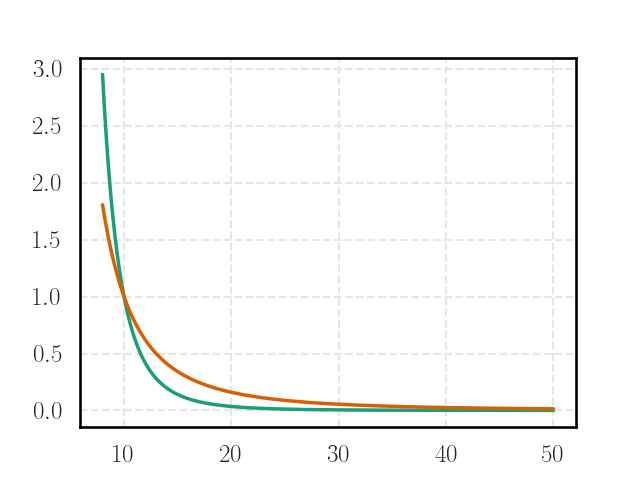

Fraction of stars more massive than 20 Msun over those more massive than 8 Msun for alpha = -4.85: 0.0283971618192818
Fraction of stars more massive than 20 Msun over those more massive than 8 Msun for alpha = -2.65: 0.18020022228005755


In [2]:
%matplotlib widget
# We will define the PDMF for stars larger than 8 Msun as a power-law

m = np.linspace(8, 50, 1000)
alpha_1 = -4.85
alpha_2 = -2.65
pmdf_1 = m ** alpha_1
pmdf_2 = m ** alpha_2

# Plot the PDMF
plt.figure()
plt.plot(m, pmdf_1 / 10 ** alpha_1)
plt.plot(m, pmdf_2 / 10 ** alpha_2)
plt.show()
plt.yscale('log')

# For each alpha, calculate the fraction of stars more massive than X Msun over those more massive than 8 Msun
cut_mass = 20
frac_1 = np.trapz(pmdf_1[m >= cut_mass], m[m >= cut_mass]) / np.trapz(pmdf_1, m)
frac_2 = np.trapz(pmdf_2[m >= cut_mass], m[m >= cut_mass]) / np.trapz(pmdf_2, m)

print(f"Fraction of stars more massive than {cut_mass} Msun over those more massive than 8 Msun for alpha = {alpha_1}: {frac_1}")
print(f"Fraction of stars more massive than {cut_mass} Msun over those more massive than 8 Msun for alpha = {alpha_2}: {frac_2}")


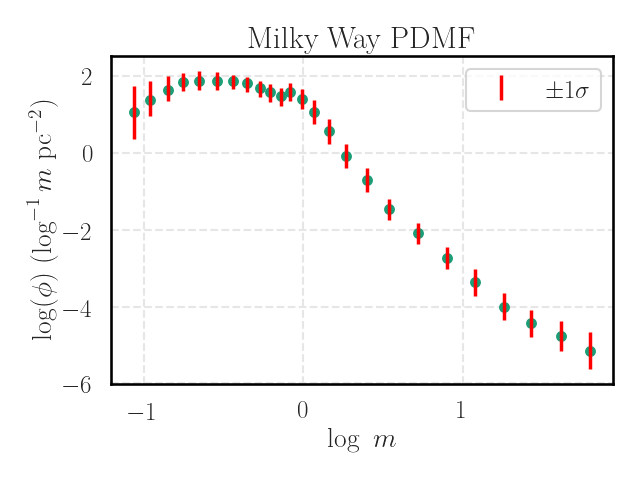

Total number of stars (in main-sequence) per unit area: 5.776e+01
Total number of stars (in main-sequence) in the Milky Way: 4.082e+10
Total number of stars in the Milky Way: 4.536e+10


In [12]:
# Load the PDMF data
# Load the PDMF data with named columns
pdmf_data = np.genfromtxt('mass_function.dat', 
                         names=['M_i', 'log_m', 'log_phi_plus_10', 'dm_d_log_m', 'two_H', 
                                'g_m', 'log_phi_log_m', 'e_log_phi_low', 'e_log_phi_high'],
                         comments='#')
# Reverse the order of the data (as it starts at the highest mass)
pdmf_data = pdmf_data[::-1]

# Plot the PDMF
log_m_data = pdmf_data["log_m"]
log_phi_data = pdmf_data["log_phi_log_m"] # log phi has units log^-1 m pc^-2
lower_error = pdmf_data["e_log_phi_low"]
upper_error = pdmf_data["e_log_phi_high"]

# Plot the PDMF with error bars
plt.figure()
plt.scatter(log_m_data, log_phi_data, s=40)
plt.errorbar(log_m_data, log_phi_data, yerr=[lower_error, upper_error], fmt='none', ecolor='red', label=r'$\pm 1\sigma$')
plt.xlabel(r'$\log\ m$')
plt.ylabel(r'$\log(\phi)$ $(\log^{-1} m$ pc$^{-2}$)')
plt.title('Milky Way PDMF')
plt.tight_layout()
plt.legend()
plt.show()

# save the figure
plt.savefig('../local_saves/plot_outputs/pdmf.pdf', bbox_inches='tight', dpi=600)

# We're gonna integrate the PDMF to get the total number of stars in the Milky Way
# We'll assume that the Milky Way is ~30 kpc in diameter and uniformly distributed
milky_way_radius = 15 # kpc
milky_way_area = np.pi * milky_way_radius ** 2 * 1e6  # pc^2
phi_data = 10 ** log_phi_data
m_data = 10 ** log_m_data

total_stars_per_unit_area_main_sequence = np.trapz(phi_data, log_m_data)
total_stars_main_sequence = total_stars_per_unit_area_main_sequence * milky_way_area

print(f"Total number of stars (in main-sequence) per unit area: {total_stars_per_unit_area_main_sequence:.3e}")
print(f"Total number of stars (in main-sequence) in the Milky Way: {total_stars_main_sequence:.3e}")

total_stars = total_stars_main_sequence / 0.9 # ~90% of stars are on the main sequence
print(f"Total number of stars in the Milky Way: {total_stars:.3e}")


Fitted power-law parameters (for m > 7.5 * Msun): slope = -2.654, intercept = -0.503


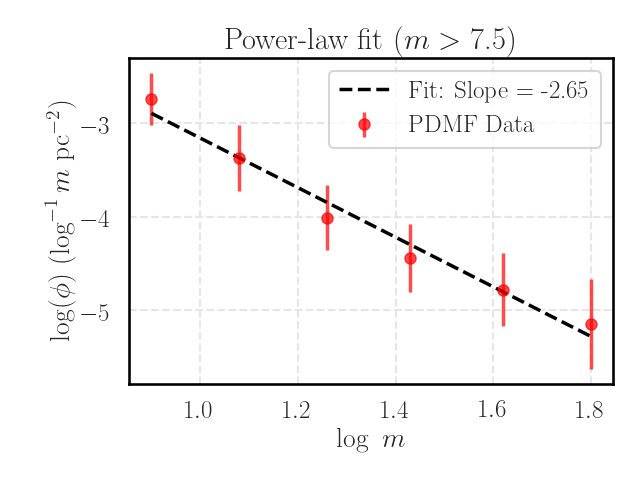

In [16]:
# Fit a power-law to the PDMF for m > n Msun
n = 7.5
mask = log_m_data > np.log10(n)

# Select the data points for the fit
x_fit = log_m_data[mask]
y_fit = log_phi_data[mask]

# Perform a linear regression (in log-log space) to fit a power-law:
# Model: log_phi = slope * log_m + intercept, which corresponds to phi(m) = 10**intercept * m^(slope)
coeffs = np.polyfit(x_fit, y_fit, 1)
fit_slope, fit_intercept = coeffs
print(f"Fitted power-law parameters (for m > {n} * Msun): slope = {fit_slope:.3f}, intercept = {fit_intercept:.3f}")

# Generate the fitted model over the range of log_m values
y_model = fit_slope * log_m_data + fit_intercept

# Plot the original PDMF data (with error bars) and overlay the fitted power-law curve
plt.figure()
plt.errorbar(log_m_data[mask], log_phi_data[mask], yerr=[lower_error[mask], upper_error[mask]], fmt='o', color='red', alpha=0.7, label='PDMF Data')
plt.plot(log_m_data[mask], y_model[mask], 'k--', label=f'Fit: Slope = {fit_slope:.2f}')
plt.xlabel(r'$\log\ m$')
plt.ylabel(r'$\log(\phi)$ $(\log^{-1} m$ pc$^{-2}$)')
plt.title(r'Power-law fit ($m>$ ' + f'{n})')
plt.legend()
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('../local_saves/plot_outputs/pdmf_fit.pdf', bbox_inches='tight', dpi=600)

--------------------------------
m_threshold: 8
Total number of SN candidates in the Milky Way PDMF: 4.647e+04
Total number of SN candidates in the Milky Way power law: 7.685e-04
Number of SN candidates that will explode per year (integrating PDMF): 1.087e-03
Number of SN candidates that will explode per year (power law): 4.389e-03
Number of SN candidates that will explode per century (power law corrected): 0.9675943444120313 to 3.870377377648125
--------------------------------
m_threshold: 10
Total number of SN candidates in the Milky Way PDMF: 4.647e+04
Total number of SN candidates in the Milky Way power law: 4.870e-04
Number of SN candidates that will explode per year (integrating PDMF): 8.470e-04
Number of SN candidates that will explode per year (power law): 3.669e-03
Number of SN candidates that will explode per century (power law corrected): 0.8089545812081619 to 3.2358183248326475
--------------------------------
m_threshold: 16.5
Total number of SN candidates in the Milky Wa

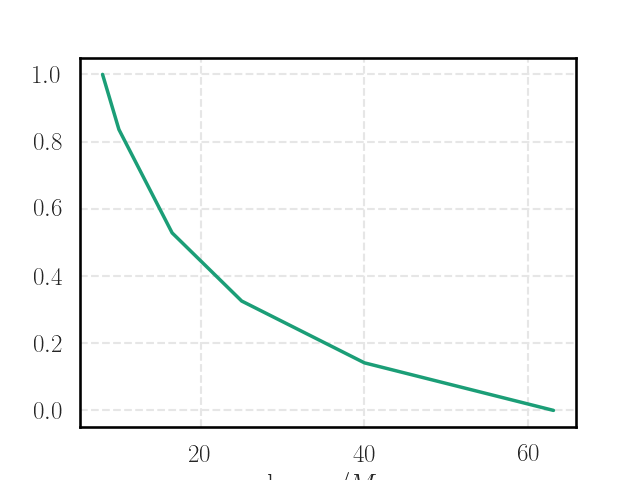

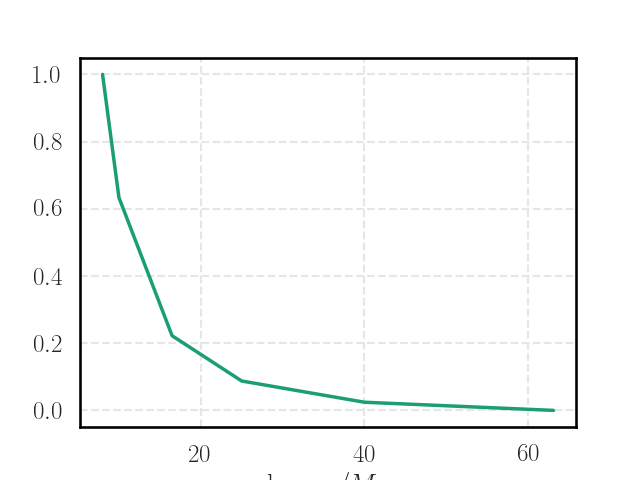

In [10]:
# We can estimate the number of SN candidates in the Milky Way by integrating the PDMF over the range of masses that produce SN explosions
# We'll assume that the mass range for SN production is > 8 Msun
upper_mass = np.max(m_data)
k = 10 ** fit_intercept * milky_way_area / np.log(10)
slope = -3.0 #fit_slope
alpha = -slope + 1

masses = np.linspace(7.5, upper_mass, 1000)
# masses = np.linspace(8, 50, 1000)
log_m = np.log10(masses)
# New 'model'
y_model_new = -3.0 * log_m - 1.0
phi_new = 10 ** y_model_new

m_lower_threshold = 8

# Nakazato provides: 13, 20, 30, 50
#m_thresholds = [8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60]
m_thresholds = [8, 10, 16.5, 25, 40, upper_mass]

n_deaths_power_law_list = []
n_deaths_power_law_list_in_interval = []
total_number_of_sn_candidates_power_law_list = []
n_candidates_power_law_list_in_interval = []

n_deaths_power_law_in_full_interval = 1e-10 * k * (upper_mass ** (2.5 - alpha + 1) - m_thresholds[0] ** (2.5 - alpha + 1)) / (2.5 - alpha + 1)
n_candidates_power_law_in_full_interval = (upper_mass ** (- alpha + 1) - m_thresholds[0] ** (- alpha + 1)) / (- alpha + 1)

for i, m_threshold in enumerate(m_thresholds):
    print(f"--------------------------------")
    print(f"m_threshold: {m_threshold}")
    threshold_mask = log_m > np.log10(m_threshold)
    threshold_mask_data = log_m_data > np.log10(m_threshold)

    prev_m_threshold = m_thresholds[0]
    if i > 0:
        prev_m_threshold = m_thresholds[i - 1]

    # print(phi[threshold_mask])
    # print(10**y_model[threshold_mask])

    total_sn_candidates_per_unit_area_pdmf = np.trapz(phi_data[threshold_mask_data], log_m_data[threshold_mask_data])
    total_sn_candidates_pdmf = total_sn_candidates_per_unit_area_pdmf * milky_way_area
    
    total_sn_candidates_per_unit_area_power_law = np.trapz(phi_new[threshold_mask], 10 ** log_m[threshold_mask])
    total_sn_candidates_power_law = total_sn_candidates_per_unit_area_power_law * milky_way_area
    total_number_of_sn_candidates_power_law_list.append(total_sn_candidates_power_law)

    #print(f"Total number of SN candidates per unit area PDMF: {total_sn_candidates_per_unit_area_pdmf:.3e}")
    print(f"Total number of SN candidates in the Milky Way PDMF: {total_sn_candidates_pdmf:.3e}")
    print(f"Total number of SN candidates in the Milky Way power law: {total_sn_candidates_per_unit_area_power_law:.3e}")

    # How many SN candidates will explode per year?
    # Assuming a power law (see notebook for derivation)

    upper_mass = np.max(m_data)
    #print(f"upper_mass: {upper_mass}")
    n_deaths_power_law = 1e-10 * k * (upper_mass ** (2.5 - alpha + 1) - m_threshold ** (2.5 - alpha + 1)) / (2.5 - alpha + 1)
    n_deaths_power_law_list.append(n_deaths_power_law)

    # What about just for the interval previous interval?
    n_deaths_power_law_in_interval = 1e-10 * k * (m_threshold ** (2.5 - alpha + 1) - prev_m_threshold ** (2.5 - alpha + 1)) / (2.5 - alpha + 1)
    n_deaths_power_law_list_in_interval.append(n_deaths_power_law_in_interval)

    # What about the number of SN candidates (not deaths)
    n_candidates_power_law_in_interval = (m_threshold ** (- alpha + 1) - prev_m_threshold ** (- alpha + 1)) / (- alpha + 1)
    n_candidates_power_law_list_in_interval.append(n_candidates_power_law_in_interval)

    # Integrating the PDMF directly
    # We showed that phi(m) * dm = phi(log_m) * d(log_m) (the m and ln 10 cancel out)
    n_deaths = 1e-10 * np.trapz(phi_new[threshold_mask] * m[threshold_mask]**2.5, log_m[threshold_mask]) \
                    * milky_way_area
    # phi_m = phi / (m * np.log(10))
    # n_deaths_2 = 1e-10 * np.trapz(phi_m[threshold_mask] * m[threshold_mask]**2.5, m[threshold_mask]) * milky_way_area
    # print(n_deaths, n_deaths_2)
    # n_deaths_3 = 1e-10 * np.trapz(10**y_model[threshold_mask] * m[threshold_mask]**2.5, log_m[threshold_mask]) * milky_way_area
    # print(n_deaths, n_deaths_3, n_deaths_power_law)

    print(f"Number of SN candidates that will explode per year (integrating PDMF): {n_deaths:.3e}")
    print(f"Number of SN candidates that will explode per year (power law): {n_deaths_power_law:.3e}")

    # This implies how many SN per century?
    correction_factor = np.array([1e11 / total_stars, 4e11 / total_stars])
    n_deaths_per_century = n_deaths * 100
    n_deaths_per_century_power_law = n_deaths_power_law * 100
    n_deaths_per_century_corrected = n_deaths * 100 * correction_factor
    n_deaths_per_century_power_law_corrected = n_deaths_power_law * 100 * correction_factor

    # print(f"Number of SN candidates that will explode per century: {n_deaths_per_century}")
    # print(f"Number of SN candidates that will explode per century (power law): {n_deaths_per_century_power_law}")
    # print(f"Number of SN candidates that will explode per century (corrected):" +
    #         f" {n_deaths_per_century_corrected.min()} to {n_deaths_per_century_corrected.max()}")
    print(f"Number of SN candidates that will explode per century (power law corrected):" +
            f" {n_deaths_per_century_power_law_corrected.min()} to {n_deaths_per_century_power_law_corrected.max()}")



n_deaths_power_law_list = np.array(n_deaths_power_law_list)
total_number_of_sn_candidates_power_law_list = np.array(total_number_of_sn_candidates_power_law_list)
n_deaths_power_law_list_in_interval = np.array(n_deaths_power_law_list_in_interval)
n_deaths_power_law_in_full_interval_fraction = n_deaths_power_law_list_in_interval / n_deaths_power_law_in_full_interval
print(np.sum(n_deaths_power_law_in_full_interval_fraction), "asdñklfjhasdñldfja")

for i in range(len(n_deaths_power_law_list)):
    print(f"m_threshold: {m_thresholds[i]}")
    print(f"n_deaths_power_law: {n_deaths_power_law_list[i]}")
    print(f"n_deaths_power_law_in_interval: {n_deaths_power_law_list_in_interval[i]}")
    print(f"total_number_of_sn_candidates_power_law: {total_number_of_sn_candidates_power_law_list[i]}")
    print(f"n_deaths_power_law / n_deaths_power_law[0]: {n_deaths_power_law_list[i] / n_deaths_power_law_list[0]}")
    print(f"n_deaths_power_law_in_interval / total: {n_deaths_power_law_list_in_interval[i] / n_deaths_power_law_in_full_interval}")
    print(f"n_candidates_power_law_in_interval / total: {n_candidates_power_law_list_in_interval[i] / n_candidates_power_law_in_full_interval}")
    print(f"total_number_of_sn_candidates_power_law / total_number_of_sn_candidates_power_law[0]: {total_number_of_sn_candidates_power_law_list[i] / total_number_of_sn_candidates_power_law_list[0]}")
    print(f"--------------------------------")

# plot...
plt.figure()
plt.plot(m_thresholds, n_deaths_power_law_list / n_deaths_power_law_list[0])
plt.xlabel(r'$\log\ m/M_{\odot}$')
plt.show()

plt.figure()
plt.plot(m_thresholds, total_number_of_sn_candidates_power_law_list / total_number_of_sn_candidates_power_law_list[0])
plt.xlabel(r'$\log\ m/M_{\odot}$')
plt.show()